<center><h1> PyF2F - Image Registration Notebook </h1></center>

To achieve accurate distance measurements between two fluorophores that emit at different wavelengths, it is crucial to register the positions of the two fluorophores obtained in the two channels. This notebook runs the functionalities of PyF2F-Ruler to calculate the chromatic shift between the two color positions (corresponding to the the two channels) over the entire field of view at the nanometer scale.

### Scientific IPython Setup

Before starting, we need to :
1. Scientific IPython Setup
2. Set parameters to run the image registration workflow
3. Set paths to working directories

<h3>1. Scientific IPython Setup </h3>

Load some required scientific Python libraries:

In [1]:
%load_ext autoreload
%autoreload 2

import os
import glob
import shutil
import sys
import time
import pandas as pd
import numpy as np
import trackpy as tp
import pims
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import tkinter as tk
from tkinter import filedialog
from skimage import io, util
from skimage import data
from scipy import stats
from scipy import spatial
from pymicro.view.vol_utils import compute_affine_transform
from matplotlib import rcParams

as well as PyF2F-Ruler's custom functions:

In [2]:
# Append PyF2F scripts path and import functions
sys.path.append(os.getcwd() + '/scripts/')
from detect_beads import *
%aimport detect_beads

<h3>2. Parameters for Image Registration </h3>

Now, we have to set the **parameters** to run the image registration workflow. PyF2F-Ruler calculates the registration map between the two channels using a *piecewise affine transformation*, correcting spot positions locally using nearby fiducial points.

Important parameters here are the **pixel size** of the camera (*nm/px*) and the **spot diameter** (aproximate the spot size to the PSF of the microscope, actually the diameter should approximate twice the PSF of the microscope). 

The rest of the parameters help to optimize the spot detection based on intensity filters such as the **percentile** (detecting spots above a given percentile), the **mass (integrated brightness)**  (avoiding selecting low-intense spots or too high-intense spots (such as bead aggreagates). Moreover, since the local affine correction is based on a nearest-neighbor search, two parameters can influence the registration outcome: minimum number of fiducial points (**min_fiducials ~ 100**) and maximum distance to the coordinate to correct (**search_range ~ 2 $\mu m$**).

In [3]:
beads_head = "beads_*.tif"      # Beads_head (pattern in bead images)
px_size = 110                   # Zyla camera (64.5 nm/px) // Prime camera (110 nm/px) 
spot_diameter = 7               # spot detection: diameter of spots in px
percentile = 99.6               # spot detection: sort spots below this percentile of intensity 
min_mass = 0.01                 # spot detection: sort spots with a mass above this threshold (range 0-1). 
max_mass = 0.95                 # spot detection: sort spots with a mass below this threshold (range 0-1).
max_displacement=1              # linking: link spots from ch1-ch2 channels separated by this cutoff in px
search_range = 2000 // px_size  # local registration: max distance in px for nearest-neighbour search
min_fiducials = 100             # local registration: minimum number of fiducial markers to correct locally 

<h3>3. Set paths to your working directories </h3>

The last thing to go is setting the paths to the working directories. At least we should have two different directories:

- Directory with beads images to create the registration map (Beads_reg)
- Directory with beads images to calculate the error of registration (Beads_test)
- Diretory to output of registration
- Directory to outout of test

In [15]:
# Select directories where Beads_reg and Beads_test
root = tk.Tk()
root.withdraw()
path_beads_reg = filedialog.askdirectory(title="Select Directory Beads Registration") + "/"
path_beads_test = filedialog.askdirectory(title="Select Directory Beads Test") + "/"

# Create directories for output
path_output_reg = "/".join(path_beads_reg.split("/")[:-2]) + "/output_reg/"
path_output_test = "/".join(path_beads_reg.split("/")[:-2]) + "/output_test/"
if not os.path.exists(path_output_reg):
    os.mkdir(path_output_reg)
    
if not os.path.exists(path_output_test):
    os.mkdir(path_output_test)

In [33]:
print("Your Paths: \n"
          " -Beads_Reg directory: {}\n"
          " -Beads_Test directory: {}\n"
          " -Output_Reg directory: {}\n"
          " -Output_Test directory: {}\n".format(path_beads_reg,
                                                 path_beads_test,
                                                 path_output_reg,
                                                 path_output_test))                                                 

Your Paths: 
 -Beads_Reg directory: /home/altair/PycharmProjects/book_chapter_local_affine/F9/input/beads_registration_laura/
 -Beads_Test directory: /home/altair/PycharmProjects/book_chapter_local_affine/F9/input/beads_test_laura/
 -Output_Reg directory: /home/altair/PycharmProjects/book_chapter_local_affine/F9/input/output_reg/
 -Output_Test directory: /home/altair/PycharmProjects/book_chapter_local_affine/F9/input/output_test/



Now, we can calculate the Target Registration Error (TRE).

## Calculate TRE

<h3>Step 1</h3>

Get two channels (c1-c2) coordinates from the two sets of beads to a) calculate the registration map (REF) and b) to calculate the TRE (TEST). If the coordinates have been previously calculated, then are loaded from the saved CSV files in the "output_reg" and "output_test" directories.

In [39]:
######################
# 1. Get Coordinates
######################
# Check if spots have been previously detected and saved in 
# the "path_output_reg" and "path_output_test" directories  
if os.path.exists(path_output_reg + "/coords_W1.csv") and os.path.exists(path_output_reg + "/coords_W2.csv"):
    c1_ref = np.loadtxt(path_output_reg + "/coords_W1.csv", delimiter=",")
    c2_ref = np.loadtxt(path_output_reg + "/coords_W2.csv", delimiter=",")
    c1_test = np.loadtxt(path_output_test + "/coords_W1.csv", delimiter=",")
    c2_test = np.loadtxt(path_output_test + "/coords_W2.csv", delimiter=",")
    
else:
    # Get coordinates from beads for registration
    c2_ref, c1_ref = get_coords(path_output_reg, path_beads_reg, beads_head, diameter=spot_diameter, separation=max_displacement, percentile=percentile, min_mass_cutoff=min_mass, max_mass_cutoff=max_mass, px_size=px_size)
    c2_test, c1_test = get_coords(path_output_test, path_beads_test, beads_head, diameter=spot_diameter, separation=max_displacement, percentile=percentile, min_mass_cutoff=min_mass, max_mass_cutoff=max_mass, px_size=px_size)


<h3>Step 2</h3>

Apply local affine (piecewise) transformation to the TEST dataset from the REF dataset

In [40]:
######################
# 2. Piecewise Affine
######################
c1_test_new = np.empty_like(c1_test)
for i in range(len(c1_test)):
    c1_test_new[i] = piecewise_affine(c1_test[i], c1_ref, c2_ref, search_range=search_range, min_candidates=min_fiducials)

# Plot and save coordinates
plotly_coords(c1_test, c2_test, path=path_output_test, c1_corrected=c1_test_new, title=f"TEST\n N={len(c1_test)}")

<h3>Step 3</h3>

Calculate the Target Registration Error and plot the distances between c1-c2 TEST beads before and after the piecewise affine transformation

<Figure size 640x480 with 0 Axes>

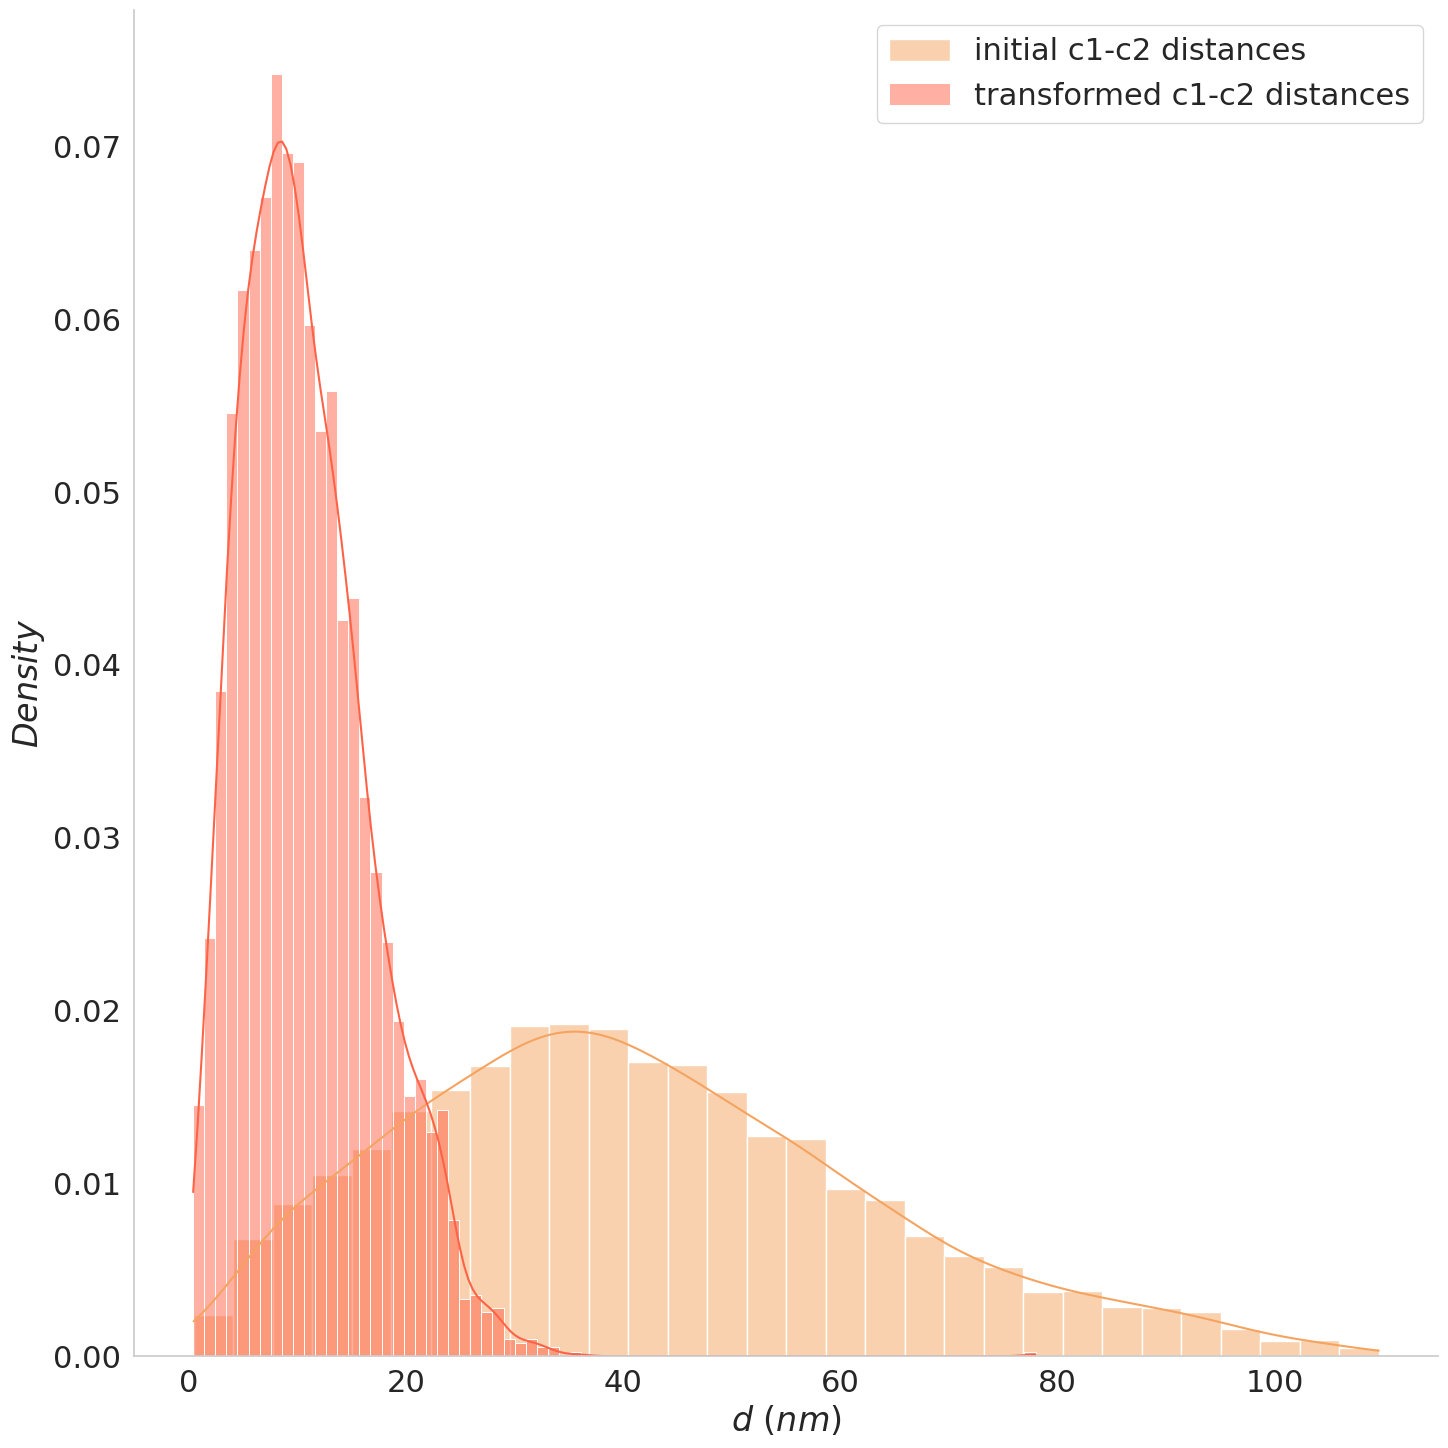

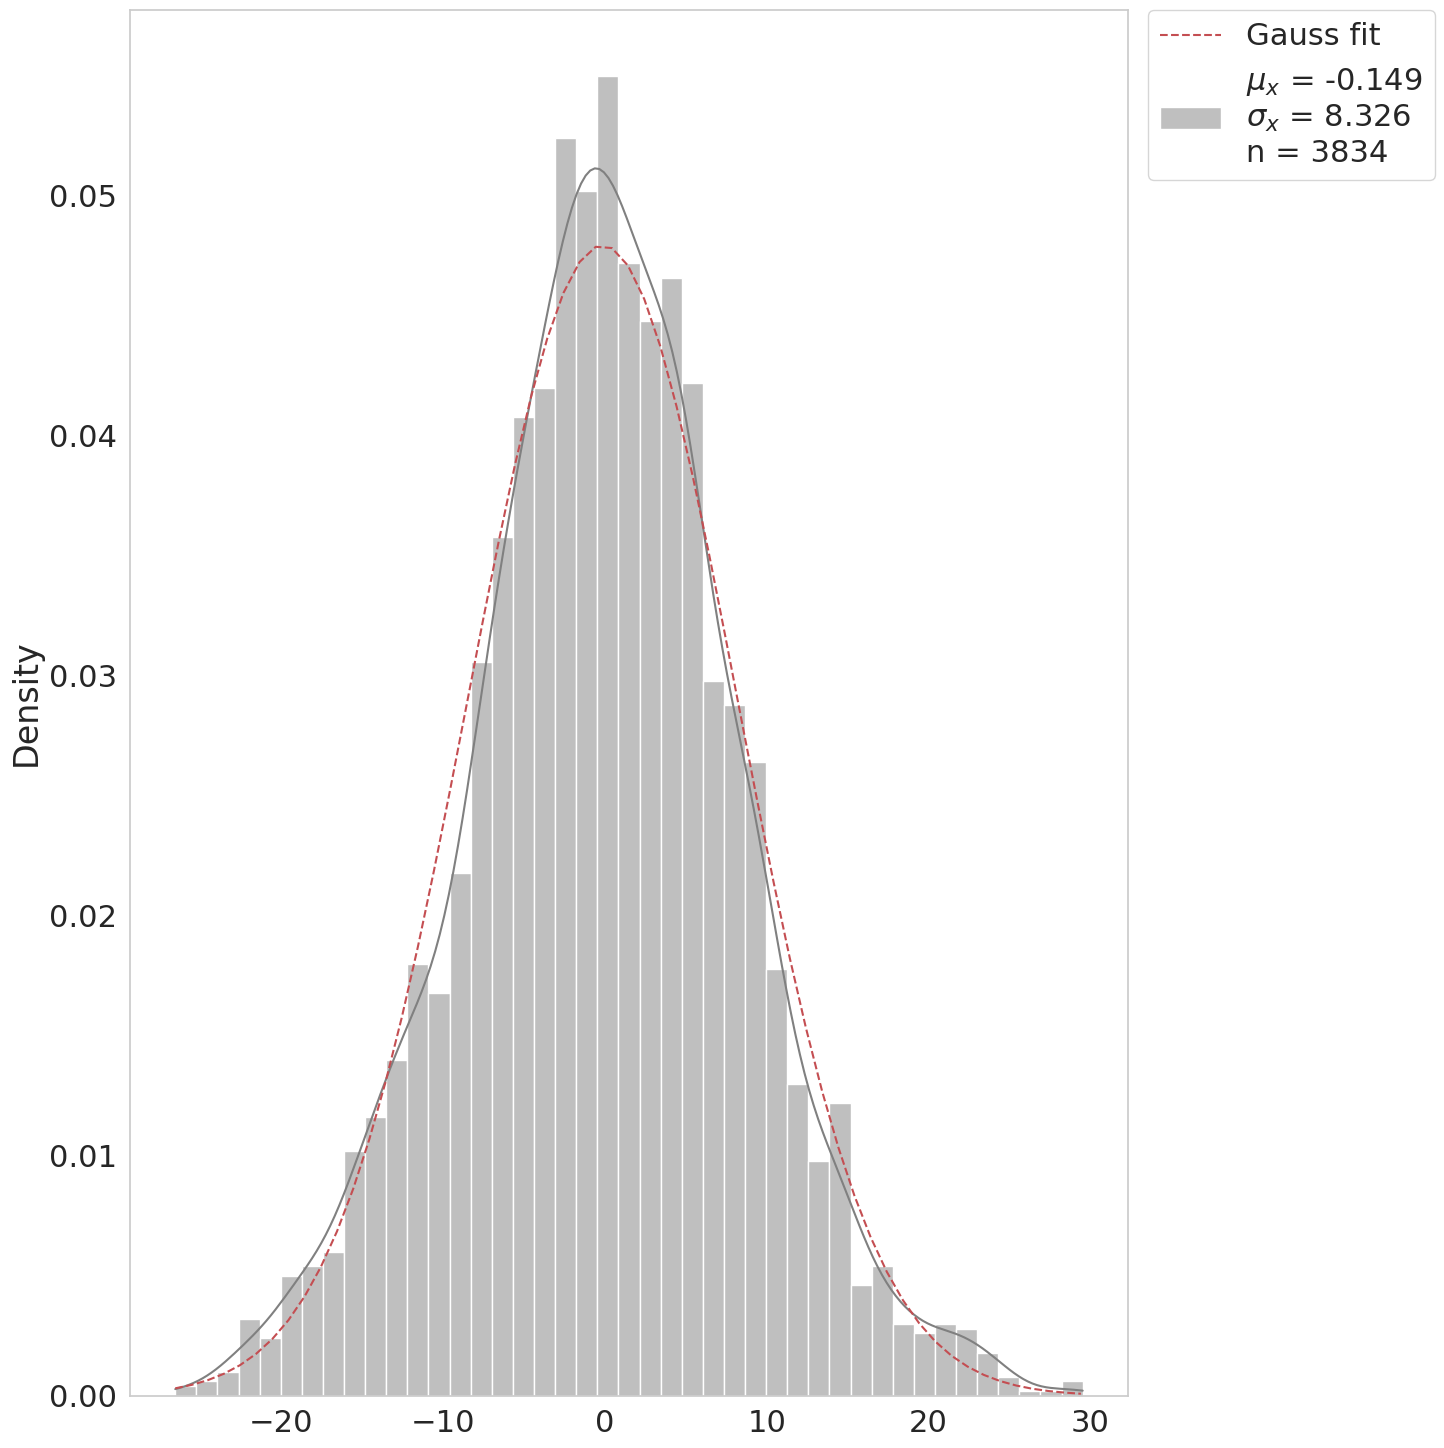

<Figure size 640x480 with 0 Axes>

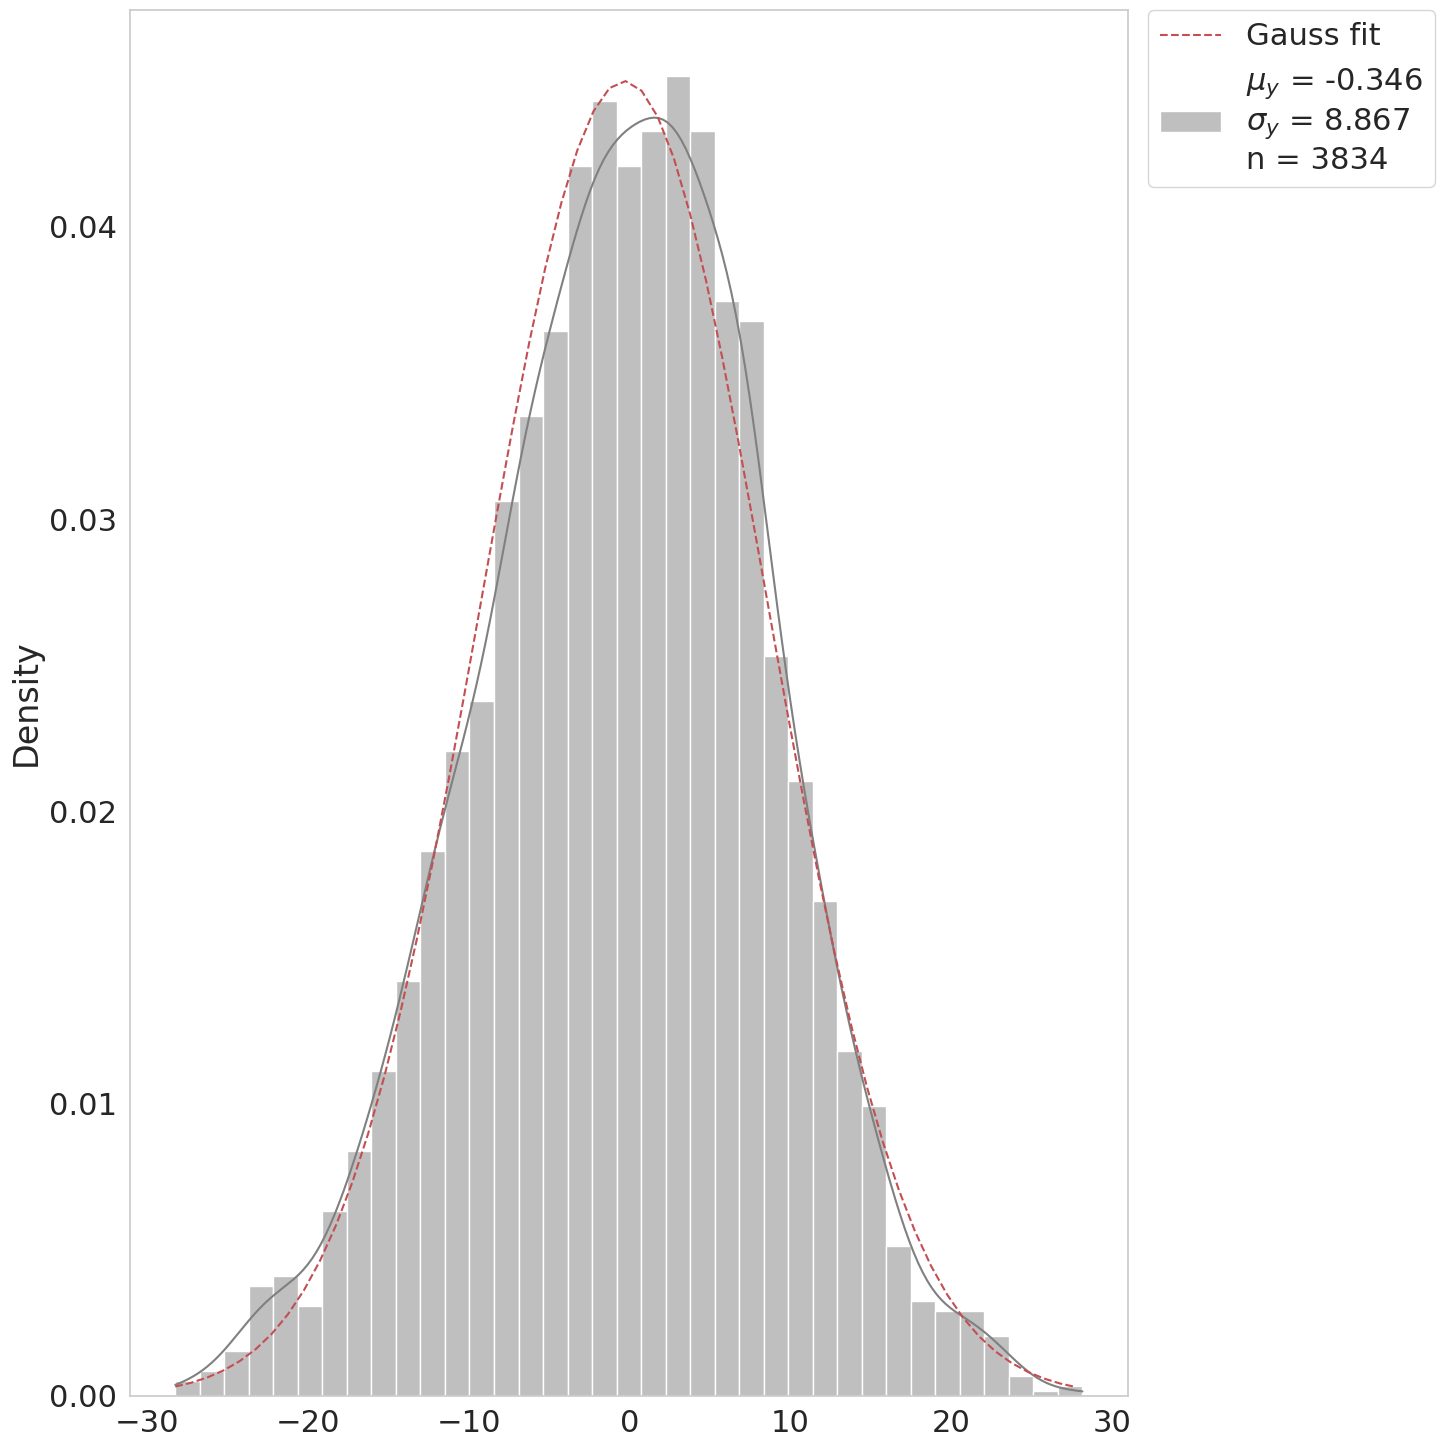

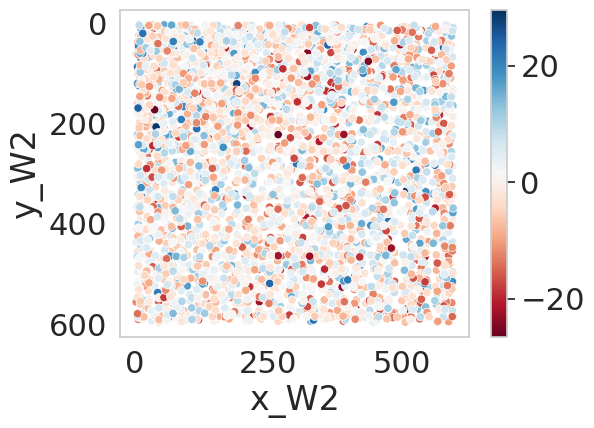

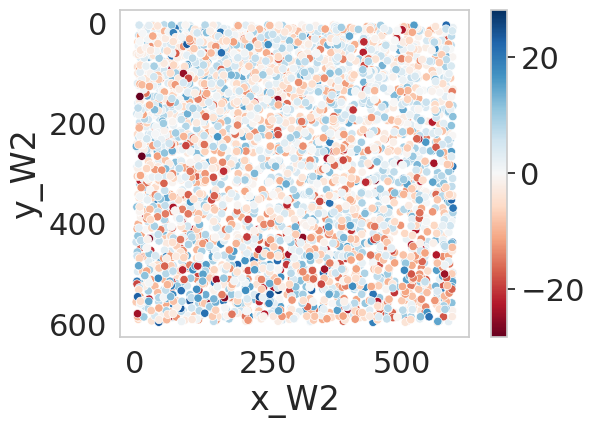

Mean shift in X axis =  -0.149 nm 

Mean shift in Y axis =  -0.346 nm 

Target Registration Error (TRE) = 0.377 nm


In [43]:
######################
# 3. Calculate TRE
######################
plot_distance_distribution(path_output_test, c2_test, c1_test, c1_test_new, px_size=px_size)
calculate_tre(path_output_test, c2_test, c1_test, c1_test_new, px_size=px_size)

## END
